In [49]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import uproot 
import awkward as ak
from pathlib import Path

from typing import Dict, List 
import re
import pickle
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,  MinMaxScaler


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset



In [50]:
training_vars = ['jet_pt', 'jet_nTracks', 'jet_trackWidth', 'jet_trackC1']
training_weight = ['equal_weight']
filename = './pytorch_MLP_classifier.model'

sample_all_jets_path = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/BDT_EB4/samples/sample_allpt_all_jets.pkl'

sample_path = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/BDT_EB4/samples/sample_allpt_all_jets.pkl'

label_pt_bin = [500, 600, 800, 1000, 1200, 1500, 2000]
n_training_vars = len(training_vars)


In [51]:
sample = pd.read_pickle(sample_path)

In [52]:
_scaler = MinMaxScaler()
#Optimizer
learning_rate = 0.001
epochs = 100
#Layer size
n_hidden1 = 10  # Number of hidden nodes
n_hidden2 = 5
n_output =  1   # Number of output nodes = for binary classifier

use_batch = False
batch_frac = 0.1

In [53]:
n_input_dim = len(training_vars)

class ChurnModel(nn.Module):
    def __init__(self):
        super(ChurnModel, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, n_hidden1) 
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_out = nn.Linear(n_hidden2, n_output) 
        
        
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)
        
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))
        
        return x
    


In [54]:
# X = sample.iloc[:, :-1]
# y = sample.iloc[:, -1]

# X_dev, X_test, y_dev,y_test = train_test_split(X, y, test_size=0.1, random_state=456)
# X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)

In [55]:
# event_weight_idx = X.columns.get_loc('event_weight')
# equal_weight_idx = X.columns.get_loc('equal_weight')
# flatpt_weight_idx = X.columns.get_loc('flatpt_weight')

In [56]:
# from sklearn.preprocessing import StandardScaler  
# scaler = StandardScaler()  

# scaler.fit(X_train[training_vars])  
# X_train[training_vars] = scaler.transform(X_train[training_vars])  
# X_val[training_vars] = scaler.transform(X_val[training_vars])  
# X_test[training_vars] = scaler.transform(X_test[training_vars])  

# Correlation 

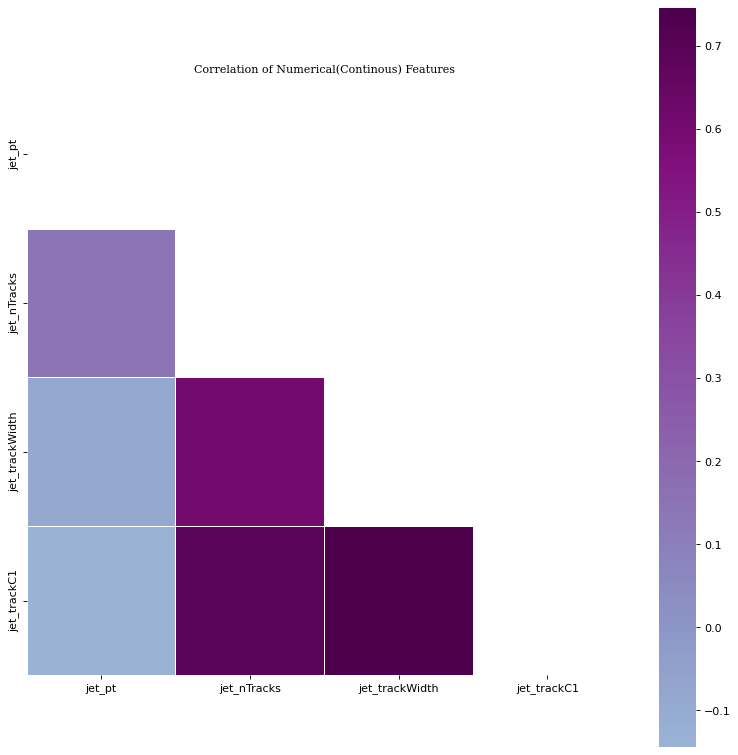

In [57]:
# #Taking all columns except URL 
# corr = sample[training_vars].corr()

# fig = plt.figure(figsize=(12,12),dpi=80)
# mask = np.triu(np.ones_like(corr, dtype=bool))
# sns.heatmap(corr, mask=mask, cmap='BuPu', robust=True, center=0,
#             square=True, linewidths=.5)
# plt.title('Correlation of Numerical(Continous) Features', fontsize=15,font="Serif")
# plt.show()

In [59]:
X = sample.iloc[:, :-1]
y = sample.iloc[:, -1]

X_dev, X_test, y_dev,y_test = train_test_split(X, y, test_size=0.1, random_state=456)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)

In [60]:
###First use a MinMaxscaler to scale all the features of Train & Test dataframes

scaler = _scaler
scaler.fit(X_train[training_vars].values)
x_train = scaler.transform(X_train[training_vars].values)
x_test =  scaler.transform(X_test[training_vars].values)
x_val =  scaler.transform(X_val[training_vars].values)

###Then convert the Train and Test sets into Tensors

x_train_tensor =  torch.from_numpy(x_train).float()
y_train_tensor =  torch.from_numpy(y_train.values.ravel()).float().unsqueeze(1)


x_test_tensor =  torch.from_numpy(x_test).float()
y_test_tensor =  torch.from_numpy(y_test.values.ravel()).float().unsqueeze(1)


x_val_tensor = torch.from_numpy(x_val).float()
y_val_tensor = torch.from_numpy(y_val.values.ravel()).float().unsqueeze(1)


# y_train_tensor = y_train_tensor.unsqueeze(1)
# y_test_tensor = y_test_tensor.unsqueeze(1)
# y_val_tensor = y_val_tensor.unsqueeze(1)



if use_batch:
    #Define a batch size , 
    bs = int(len(x_train_tensor) * batch_frac)
    print(bs)

    #Both x_train and y_train can be combined in a single TensorDataset, which will be easier to iterate over and slice
    train_ds = TensorDataset(x_train_tensor, y_train_tensor)
    #Pytorch’s DataLoader is responsible for managing batches. 
    #You can create a DataLoader from any Dataset. DataLoader makes it easier to iterate over batches
    train_dl = DataLoader(train_ds, batch_size=bs)


    #For the validation/test dataset
    # test_ds = TensorDataset(x_test_tensor, y_test_tensor)
    # test_loader = DataLoader(test_ds, batch_size=32)

    # val_ds = TensorDataset(x_val_tensor, y_val_tensor)
    # val_loader = DataLoader(val_ds, batch_size=32)


In [61]:
#Loss Computation
loss_func = nn.BCELoss()
loss_func2 = nn.BCELoss()

In [63]:

model = ChurnModel()
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.train()
train_loss = []
val_loss = []

if use_batch:
    for epoch in tqdm(range(epochs)):
        #Within each epoch run the subsets of data = batch sizes.
        for xb, yb in tqdm(train_dl):
            y_pred = model(xb)            # Forward Propagation
            loss = loss_func(y_pred, yb)  # Loss Computation
            optimizer.zero_grad()         # Clearing all previous gradients, setting to zero 
            loss.backward()               # Back Propagation
            optimizer.step()              # Updating the parameters 
        # y_pred = model(x_tensor)            # Forward Propagation
        # loss = loss_func(y_pred, y_tensor)  # Loss Computation
        # optimizer.zero_grad()         # Clearing all previous gradients, setting to zero 
        # loss.backward()               # Back Propagation
        # optimizer.step()              # Updating the parameters 
        
        #print("Loss in iteration :"+str(epoch)+" is: "+str(loss.item()))
            train_loss.append(loss.item())

            yval_pred = model(x_val_tensor)
            val_loss.append(loss_func2(yval_pred, y_val_tensor).item())
    print('Last iteration loss value: '+str(loss.item()))
else: 
    for epoch in tqdm(range(epochs)):
        #Within each epoch run the subsets of data = batch sizes.
        # for xb, yb in tqdm(train_dl):
        #     y_pred = model(xb)            # Forward Propagation
        #     loss = loss_func(y_pred, yb)  # Loss Computation
        #     optimizer.zero_grad()         # Clearing all previous gradients, setting to zero 
        #     loss.backward()               # Back Propagation
        #     optimizer.step()              # Updating the parameters 
        y_pred = model(x_train_tensor)            # Forward Propagation
        loss = loss_func(y_pred, y_train_tensor)  # Loss Computation
        optimizer.zero_grad()         # Clearing all previous gradients, setting to zero 
        loss.backward()               # Back Propagation
        optimizer.step()              # Updating the parameters 
        
        #print("Loss in iteration :"+str(epoch)+" is: "+str(loss.item()))
        train_loss.append(loss.item())

        yval_pred = model(x_val_tensor)
        val_loss.append(loss_func2(yval_pred, y_val_tensor).item())
    print('Last iteration loss value: '+str(loss.item()))

ChurnModel(
  (layer_1): Linear(in_features=4, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=5, bias=True)
  (layer_out): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


100%|██████████| 10/10 [02:06<00:00, 12.60s/it]

Last iteration loss value: 0.6604994535446167


In [64]:
y_pred.max()

tensor(0.9729, grad_fn=<MaxBackward1>)

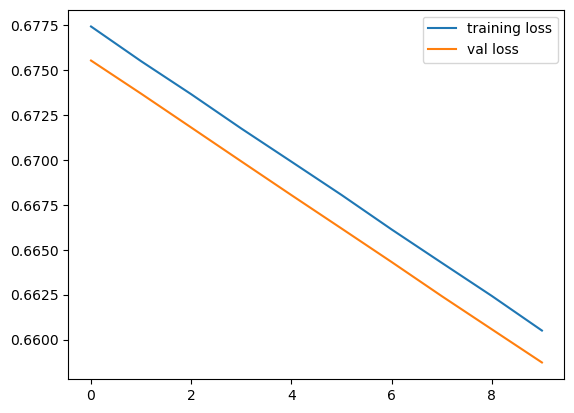

In [65]:
plt.plot(train_loss, label = 'training loss')
plt.plot(val_loss, label = 'val loss')
plt.legend()
plt.show()

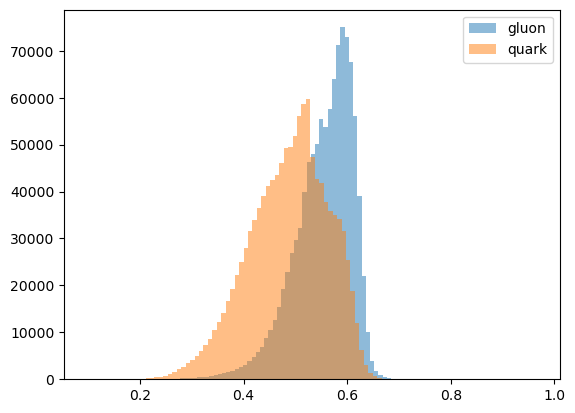

In [68]:
y_test_pred = model(x_test_tensor).detach().numpy().ravel()
plt.hist(y_test_pred[y_test == 1], bins = 101, alpha = 0.5, weights=X_test[y_test == 1]['event_weight'], label='gluon')
plt.hist(y_test_pred[y_test == 0], bins = 101, alpha = 0.5, weights=X_test[y_test == 0]['event_weight'], label='quark')
plt.legend()
plt.title('prob distribution on test dataset')
plt.savefig('test_distribution')
plt.show()

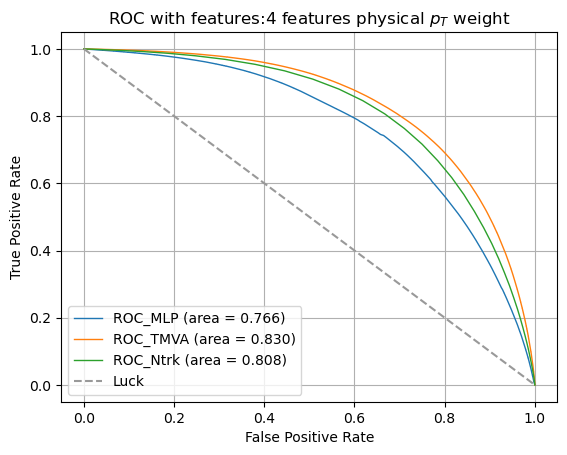

In [69]:
from sklearn.metrics import roc_curve, auc

def Draw_ROC_all(y, decisions, y_tmva, y_ntrk, X_weight, features):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y, decisions, sample_weight = X_weight)
    fpr_tmva, tpr_tmva, thresholds_tmva = roc_curve(y, y_tmva, sample_weight = X_weight)
    fpr_ntrk, tpr_ntrk, thresholds_ntrk =  roc_curve(y, y_ntrk, sample_weight = X_weight)

    roc_auc = auc(fpr, tpr)
    roc_auc_tmva = auc(fpr_tmva, tpr_tmva)
    roc_auc_ntrk = auc(fpr_ntrk, tpr_ntrk)


    plt.plot(1-fpr, tpr, lw=1, label='ROC_MLP (area = %0.3f)'%(roc_auc))
    plt.plot(1-fpr_tmva, tpr_tmva, lw=1, label='ROC_TMVA (area = %0.3f)'%(roc_auc_tmva))
    plt.plot(1-fpr_ntrk, tpr_ntrk, lw=1, label='ROC_Ntrk (area = %0.3f)'%(roc_auc_ntrk))

    plt.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC with features:{features}'+r" physical $p_{T}$ weight")
    plt.legend(loc="lower left")
    plt.grid()
    plt.savefig("ROC.png")
    plt.show()

Draw_ROC_all(y_test, y_test_pred, y_tmva=X_test.iloc[:,X_test.columns.get_loc('jet_trackBDT')] , y_ntrk=X_test.iloc[:,X_test.columns.get_loc('jet_nTracks')], X_weight=X_test['event_weight'], features="4 features")


In [ ]:
x_sample_tensor = torch.from_numpy(scaler.transform(sample[training_vars].values)).float()

y_sample_pred = model(x_sample_tensor)
sample['new_pytorch_MLPprob'] = y_sample_pred.detach().numpy().ravel()

In [ ]:
sample.to_pickle('pred_sample.pkl')